A script for using U-Net to recreate the input image. This also includes training the network to remove scratches from the original images. 


In [ ]:
!pip install keras-unet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
import random as python_random
import os

my_seed = 123


os.environ['PYTHONHASHSEED']=str(my_seed)

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(my_seed)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(my_seed)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(my_seed)


In [ ]:
!ls "/content/drive/My Drive/Skola/Tillämpad Bioinformatik (slutkursen)/Code/keras-unet/"

%cd "/content/drive/My Drive/Skola/Tillämpad Bioinformatik (slutkursen)/Code/keras-unet/"

!python setup.py install 

build			       model.UNet_L2_F24_S9x9_adam.h5
CHANGELOG.md		       model.UNet_L2_F24_S9x9_sgd.h5
dist			       model.UNet_L3_F12_S5x5_adam.h5
docs			       model.UNet_L3_F12_S5x5_sgd.h5
input			       model.UNet_L3_F16_S9x9_adam.h5
keras_unet		       notebooks
keras_unet.egg-info	       README.md
LICENSE			       requirements.txt
model.UNet_L1_F8_S3x3_adam.h5  setup.py
model.UNet_L1_F8_S3x3_sgd.h5   tests
/content/drive/My Drive/Skola/Tillämpad Bioinformatik (slutkursen)/Code/keras-unet
running install
running bdist_egg
running egg_info
writing keras_unet.egg-info/PKG-INFO
writing dependency_links to keras_unet.egg-info/dependency_links.txt
writing top-level names to keras_unet.egg-info/top_level.txt
reading manifest file 'keras_unet.egg-info/SOURCES.txt'
writing manifest file 'keras_unet.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/keras_une

In [ ]:
#import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import sys
from PIL import Image
#import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from keras_unet.utils import plot_imgs
from sklearn.model_selection import train_test_split
from keras_unet.models import custom_unet
from keras.callbacks import ModelCheckpoint
from keras_unet.metrics import iou, iou_thresholded
from keras.optimizers import Adam, SGD
from keras_unet.utils import get_augmented
from keras_unet.utils import plot_segm_history
from sklearn.preprocessing import label_binarize
import time
from sklearn.metrics import roc_curve, auc, roc_auc_score
import csv
import time
from matplotlib.pyplot import cm
from cycler import cycler
import math
import copy

%cd "/content/"

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------
/content


In [ ]:
train_images = sorted(glob.glob("/content/drive/My Drive/UNet/TrainingImages/*.tif"))
train_masks = sorted(glob.glob("/content/drive/My Drive/UNet/TrainingLabels/*.tif"))

test_images = sorted(glob.glob("/content/drive/My Drive/UNet/IndependentTestImages/*.tif"))
test_masks = sorted(glob.glob("/content/drive/My Drive/UNet/IndependentTestLabels/*.tif"))

In [ ]:
# Modified to replace the bg with grey on the mask

def prepare_images_masks(images, masks):
    
    I_list = []
    M_list = []
    for image, mask in zip(images, masks):
        I = Image.open(image)
        M = Image.open(mask)

        I = np.array(I)
        I = I/I.max()
        M = np.array(M)
        M = M/M.max()
        
        M_indices_zero = M == 0
        M_indices_ones = M == 1
        mean_bg = np.mean(I[M_indices_zero])
        M = np.multiply(M,I)
        M[M_indices_zero] = mean_bg

        I_list.append(I/(I.max()))
        M_list.append(M/(M.max()))

    X = np.asarray(I_list, dtype=np.float32)
    Y = np.asarray(M_list, dtype=np.float32)

    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1) 
    Y = Y.reshape(Y.shape[0], Y.shape[1], Y.shape[2], 1)
    
    return X, Y


X, Y = prepare_images_masks(train_images, train_masks)
X_test, Y_test = prepare_images_masks(test_images, test_masks)

0.3173519010018802
0.317301893592659
0.3185634695418014
0.31742461445743264
0.3166846318428926
0.3180085939092784
0.31952915361384543
0.32045542714266084
0.31896328162276905
0.3187506064198121
0.3202795055517951
0.3231811983610734


In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, train_size=0.75, random_state=33)

print("# X_train: %d" % X_train.shape[0])
print("# Y_train: %d" % Y_train.shape[0])
print("# X_val: %d" % X_val.shape[0])
print("# Y_val: %d" % Y_val.shape[0])

# X_train: 6
# Y_train: 6
# X_val: 2
# Y_val: 2


198400
(400, 496)


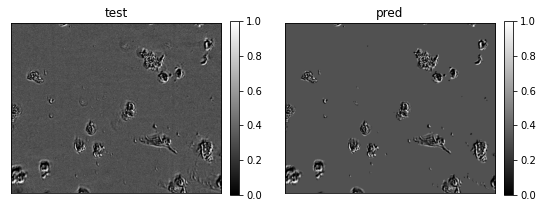

In [ ]:
# Plot one of the "masks"
fig, ax = plt.subplots(1, 2, figsize = (9, 5))

train = copy.deepcopy(X_train[0, :, :, 0])
mask = copy.deepcopy(Y_train[0, :, :, 0])

im1 = ax[0].imshow(train, cmap = 'gray')
ax[0].set_title('test')
ax[0].set_xticks([])
ax[0].set_yticks([])
fig.colorbar(im1, ax = ax[0], fraction = 0.038, pad = 0.04)

im2 = ax[1].imshow(mask, cmap = 'gray')
ax[1].set_title('pred')
ax[1].set_xticks([])
ax[1].set_yticks([])
fig.colorbar(im2, ax = ax[1], fraction = 0.038, pad = 0.04)

print(np.size(train))
print(np.shape(train))

In [ ]:
train_gen = get_augmented(
    X_train, Y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=360.0,
        fill_mode='constant')
)

In [ ]:
# Parameters
#layers = [1,2,3,4]
#layers = [3,4]
#filters = [8,12,16,24,32]
#kernel_sizes = [3,5]

layers = [3]
filters = [16]
kernel_sizes = [5]

In [ ]:
input_shape = X_train[0].shape
#i = 0

# Initialize arrays for saving data: shape, time elapsed, auc, fpr, tpr
shapes = []
time_elapsed = []
rmse_list = []
fpr_list = []
tpr_list = []

# For larger plot
plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

plt.figure()
lw = 2

# Initialize color cycle
n_lines = len(layers)*len(filters)*len(kernel_sizes)
colors=cm.rainbow(np.linspace(0,1,n_lines))

plt.rc('axes', prop_cycle=(cycler('color', colors)))

for layer in layers:
  for filter in filters:
    for kernel in kernel_sizes:
      

      # Define net architecture
      model = custom_unet(
        input_shape,
        filters=filter,
        kernel_size=(kernel, kernel), 
        num_layers=layer,
        output_activation = None
      )

      # Define file name
      model_filename = f'UNet_L{layer}_F{filter}_S{kernel}x{kernel}.h5'
      

      my_callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=20),
        tf.keras.callbacks.ModelCheckpoint(filepath='model.' + model_filename,
                                          verbose=1, 
                                          monitor='val_loss', 
                                          save_best_only=True)
      ]

      model.compile(
        optimizer=Adam(), 
        #optimizer=SGD(lr=0.0001, momentum=0.9),
        loss='mean_squared_error',
        metrics=[tf.keras.metrics.MeanSquaredError()]
      )

      start_time = time.time()
      
      history = model.fit(
        train_gen,
        steps_per_epoch=10,
        epochs=500,
        validation_data=(X_val, Y_val),
        callbacks=[my_callbacks],
        verbose = 0
      )

      end_time = time.time()
      elapsed_time = (end_time - start_time)/60

      # Saved your trained model to Google Drive in the same directory as all images for later use if needed
      #model.save(F"/content/drive/My Drive/Skola/Tillämpad Bioinformatik (slutkursen)/Unet-output/{model_filename}")

      # Prediction
      Y_pred = model.predict(X_test)

      N_Y_pred = Y_pred.shape[0]
      Y_score = np.empty(())
      Y_true = np.array(())

      for i in range(N_Y_pred):
          I_score = Y_pred[i, :, :, :]
          I_score = I_score.flatten()
          
          I_true = Y_test[i, :, :, :]
          I_true = I_true.flatten()


          
          if i == 0:
              Y_score = I_score
              Y_true = I_true
          else:
              Y_score = np.concatenate((Y_score, I_score), axis = 0)
              Y_true = np.concatenate((Y_true, I_true), axis = 0)
          

      # Calculate the RMSE
      RMSE = np.sqrt(np.sum(np.power((Y_score-Y_true),2))/np.size(Y_score))

      # Add values
      shapes.append(f'L{layer}_F{filter}_S{kernel}x{kernel}')
      time_elapsed.append(elapsed_time)
      rmse_list.append(RMSE)

      
timestr = time.strftime("%Y%m%d-%H%M%S")

with open(f"/content/drive/My Drive/Skola/Tillämpad Bioinformatik (slutkursen)/Unet-output/recreatingImage_run_{timestr}.csv", 'w', newline='') as myfile:
  wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
  for i in range(len(layers)*len(filters)*len(kernel_sizes)):
    wr.writerow([shapes[i], time_elapsed[i], rmse_list[i]])



Epoch 00001: val_loss improved from inf to 1511.46753, saving model to model.UNet_L3_F16_S5x5.h5

Epoch 00002: val_loss did not improve from 1511.46753

Epoch 00003: val_loss improved from 1511.46753 to 297.63431, saving model to model.UNet_L3_F16_S5x5.h5

Epoch 00004: val_loss improved from 297.63431 to 20.14625, saving model to model.UNet_L3_F16_S5x5.h5

Epoch 00005: val_loss improved from 20.14625 to 0.48852, saving model to model.UNet_L3_F16_S5x5.h5

Epoch 00006: val_loss improved from 0.48852 to 0.07598, saving model to model.UNet_L3_F16_S5x5.h5

Epoch 00007: val_loss improved from 0.07598 to 0.05206, saving model to model.UNet_L3_F16_S5x5.h5

Epoch 00008: val_loss did not improve from 0.05206

Epoch 00009: val_loss did not improve from 0.05206

Epoch 00010: val_loss did not improve from 0.05206

Epoch 00011: val_loss improved from 0.05206 to 0.05078, saving model to model.UNet_L3_F16_S5x5.h5

Epoch 00012: val_loss improved from 0.05078 to 0.03722, saving model to model.UNet_L3_F

<Figure size 700x700 with 0 Axes>

In [ ]:
# Trying to extract the compressed data
extractor = keras.Model(inputs=model.inputs,
                        outputs=[layer.output for layer in model.layers])
features = extractor(X_test)

In [ ]:
# Plot the different layers in the network
model.layers


43
22
tf.Tensor([  4  50  62 128], shape=(4,), dtype=int32)
tf.Tensor(
[0.         0.9545406  0.6813009  1.7456002  0.         0.5656911
 1.4390959  0.16744117 0.49861112 0.         2.115884   0.4064543
 0.9401976  0.01631937 0.         0.         0.         0.
 0.12389244 0.7456819  0.7174338  0.54849666 0.         0.
 0.         0.11415278 0.44906327 0.         0.         0.77723426
 0.79273355 0.22341068 0.53855115 0.56314826 0.2780184  0.19898723
 0.         1.0584668  1.0551744  0.         1.1667262  0.
 0.         0.         0.19670513 0.5079535  0.         0.87053365
 0.         0.05380978 0.         0.5253407  0.9593042  1.5649321
 0.         0.         0.         0.         0.         0.02300502
 2.2504013  0.         0.         0.         0.         0.
 0.40649462 0.         0.83502716 0.58714294 0.         0.41781968
 0.8034488  0.542702   0.3234257  1.2017282  0.36864746 0.3796879
 0.53246695 0.8654463  0.         0.         0.31485507 0.
 0.         1.3137735  0.         0

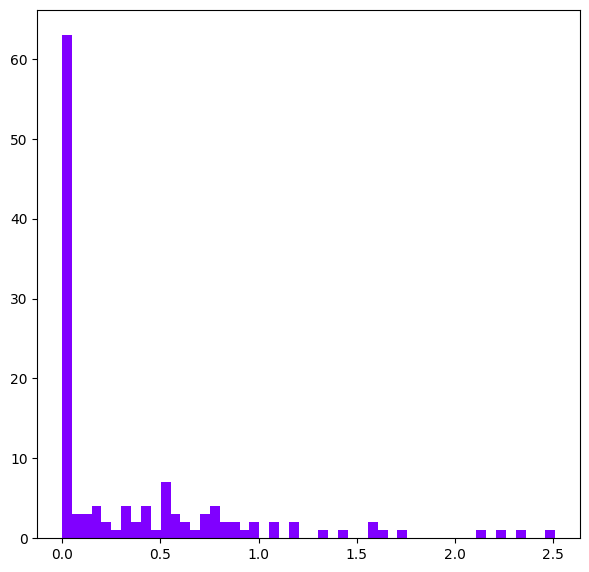

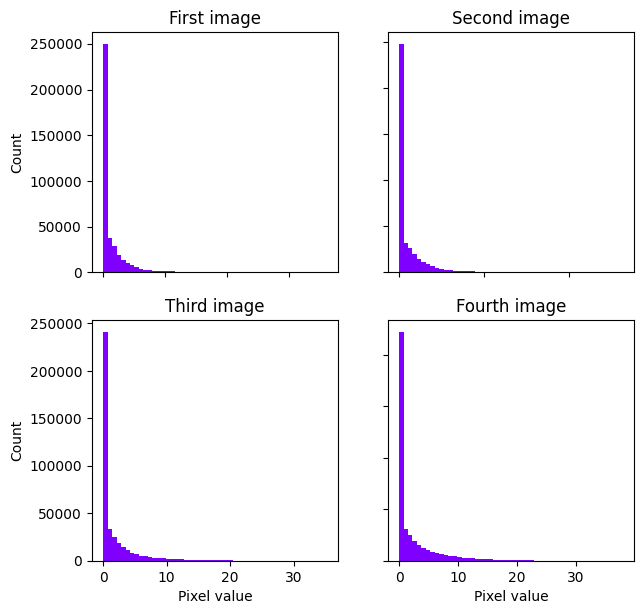

In [ ]:
# Summarizes and plots the values for each image
# Right now hard coded to only plot in a 2 by 2 subplot

print(len(features))
middle_layer = math.ceil(len(features)/2)
print(middle_layer)
print(tf.shape(features[middle_layer]))

compressed_values = []
for i in range(len(X_test)):
  compressed_values.append([])

index = 0
for i in features[middle_layer]:
  for j in i:
    for k in j:
      for l in k:
        compressed_values[index].append(l)
  index = index+1

print(len(compressed_values))

fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(compressed_values[0],bins=50)
axs[0, 0].set_title('First image')
axs[0, 1].hist(compressed_values[1],bins=50)
axs[0, 1].set_title('Second image')
axs[1, 0].hist(compressed_values[2],bins=50)
axs[1, 0].set_title('Third image')
axs[1, 1].hist(compressed_values[3],bins=50)
axs[1, 1].set_title('Fourth image')

for ax in axs.flat:
    ax.set(xlabel='Pixel value', ylabel='Count')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()


Text(0.5, 1.0, 'Compressed image')

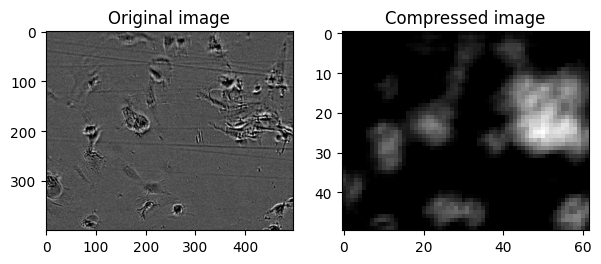

In [ ]:
# Plots an example of a compressed feature map

x_test = copy.deepcopy(X_test[0, :, :, 0])
middle_test = copy.deepcopy(features[middle_layer][:][:][0])

fig, axs = plt.subplots(1, 2)
axs[0].imshow(x_test, cmap = 'gray')
axs[0].set_title('Original image')
axs[1].imshow(middle_test[:,:,0], cmap = 'gray')
axs[1].set_title('Compressed image')



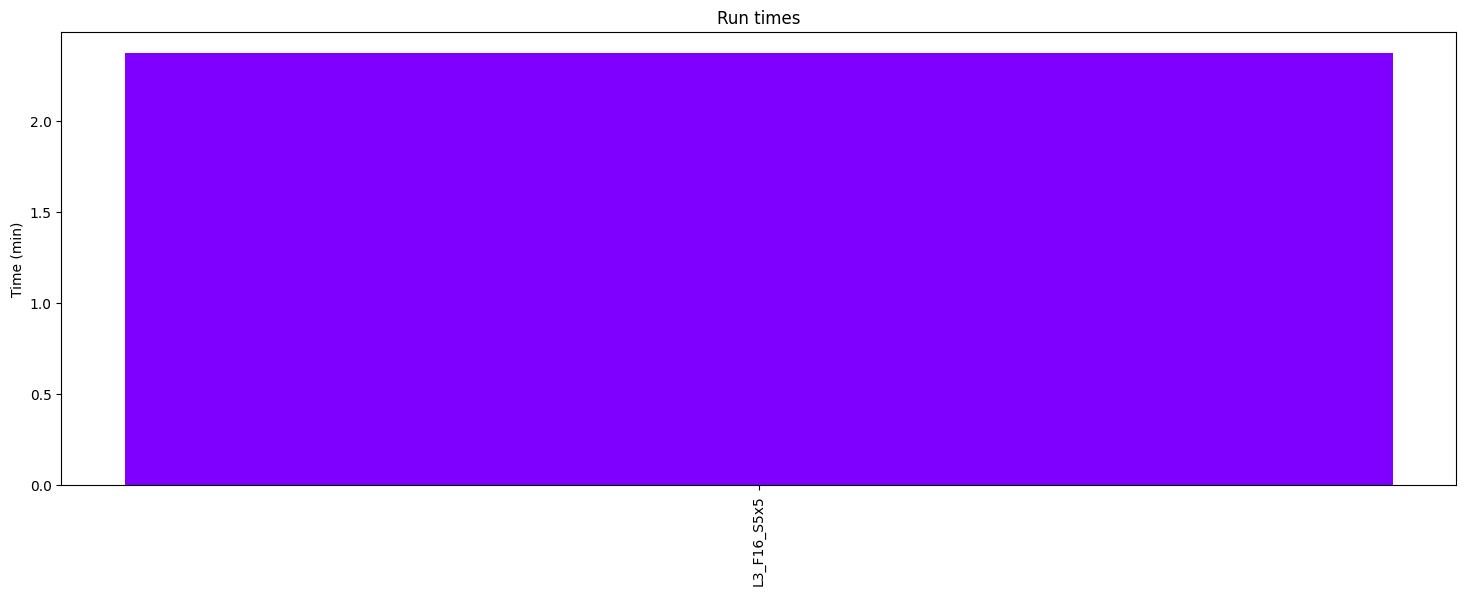

In [ ]:
from matplotlib.pyplot import cm
from cycler import cycler

# Print the time it took for reach run
with open(f'/content/drive/My Drive/Skola/Tillämpad Bioinformatik (slutkursen)/Unet-output/recreatingImage_run_{timestr}.csv', mode='r') as infile:
    reader = csv.reader(infile)
    D = {rows[0]:float(rows[1]) for rows in reader}


# For larger plot
plt.rcParams['figure.figsize'] = [18, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

plt.figure()

# Initialize color set
n_lines = len(layers)*len(filters)
colors=cm.rainbow(np.linspace(0,1,n_lines))

plt.bar(list(D.keys()), list(D.values()), color=colors)
plt.title('Run times')
plt.ylabel('Time (min)')
plt.xticks(rotation='vertical')
plt.show()

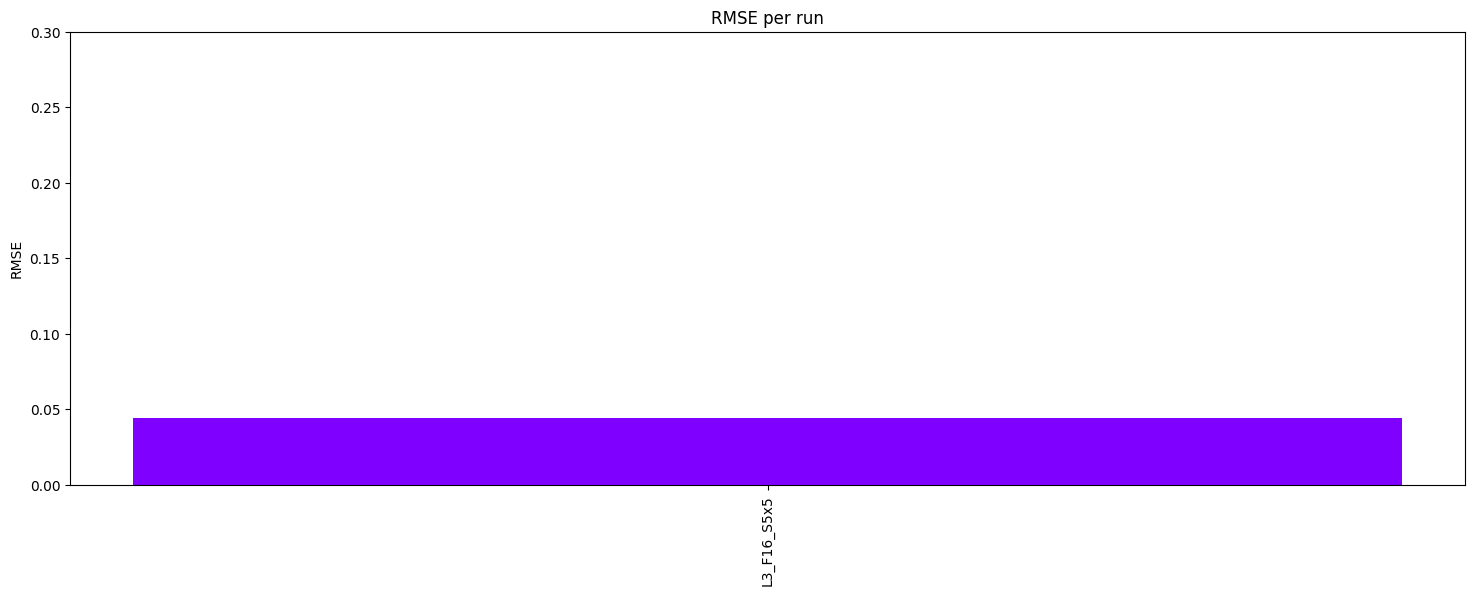

In [ ]:
from matplotlib.pyplot import cm
from cycler import cycler

# Print the RMSE for reach run
with open(f'/content/drive/My Drive/Skola/Tillämpad Bioinformatik (slutkursen)/Unet-output/recreatingImage_run_{timestr}.csv', mode='r') as infile:
    reader = csv.reader(infile)
    D = {rows[0]:float(rows[2]) for rows in reader}


# For larger plot
plt.rcParams['figure.figsize'] = [18, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

plt.figure()

# Initialize color set
n_lines = len(layers)*len(filters)
colors=cm.rainbow(np.linspace(0,1,n_lines))

plt.ylim([0.0, 0.3])
plt.bar(list(D.keys()), list(D.values()), color=colors)
plt.title('RMSE per run')
plt.ylabel('RMSE')
plt.xticks(rotation='vertical')
plt.show()

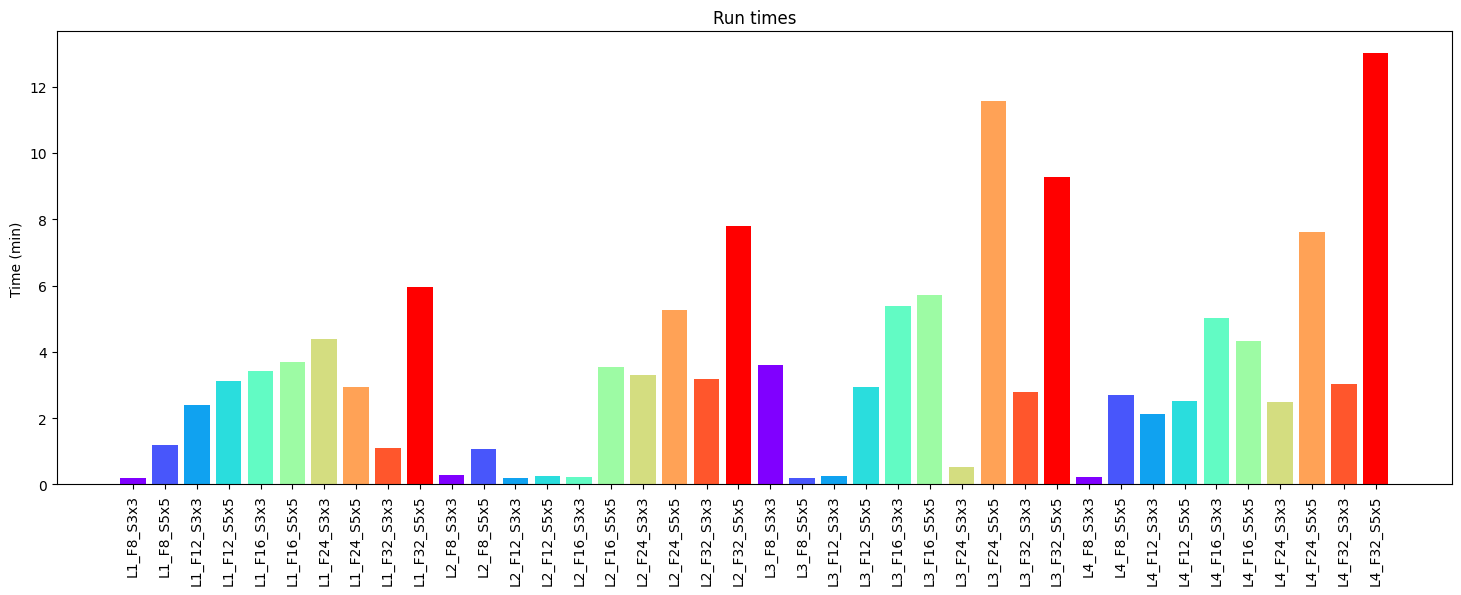

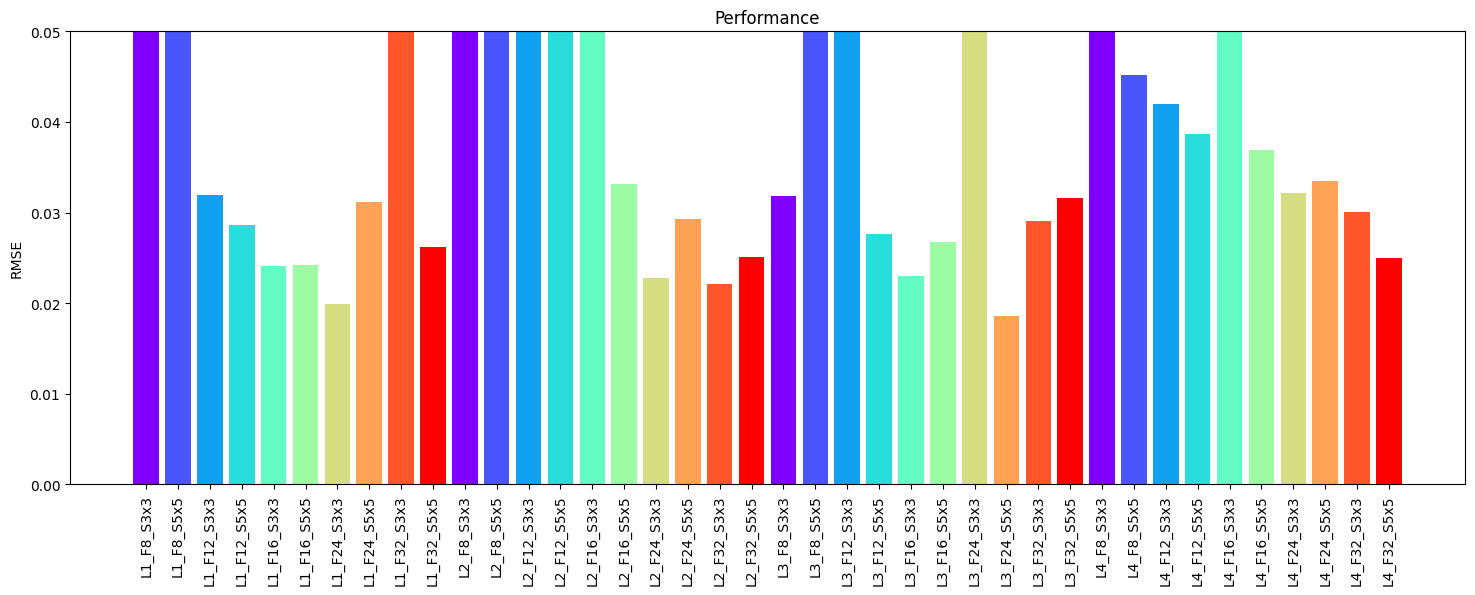

In [ ]:
# For plotting the large run performed

models = []
times = []
performances = []

# Print the time it took for reach run
#with open(f'/content/drive/My Drive/Skola/Tillämpad Bioinformatik (slutkursen)/Unet-output/recreatingImage_run_20201202-103832.csv', mode='r') as infile:
with open(f'/content/drive/My Drive/Skola/Tillämpad Bioinformatik (slutkursen)/Unet-output/recreatingImage_run_20201202-114811.csv', mode='r') as infile:
    reader = csv.reader(infile)
    for rows in reader:
      models.append(rows[0])
      times.append(float(rows[1]))
      performances.append(float(rows[2]))
    #D = {rows[0]:float(rows[1]) for rows in reader}

#with open(f'/content/drive/My Drive/Skola/Tillämpad Bioinformatik (slutkursen)/Unet-output/recreatingImage_run_20201202-113948.csv', mode='r') as infile:
with open(f'/content/drive/My Drive/Skola/Tillämpad Bioinformatik (slutkursen)/Unet-output/recreatingImage_run_20201202-130936.csv', mode='r') as infile:
    reader = csv.reader(infile)
    for rows in reader:
      models.append(rows[0])
      times.append(float(rows[1]))
      performances.append(float(rows[2]))
    #D = {rows[0]:float(rows[1]) for rows in reader}


# For larger plot
plt.rcParams['figure.figsize'] = [18, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

plt.figure()
#lw = 2

# Initialize color set
n_lines = len(layers)*len(filters)
colors=cm.rainbow(np.linspace(0,1,n_lines))


# Change the bar colors here
#plt.bar(list(D.keys()), list(D.values()), color=colors)
plt.bar(models,times,color=colors)
plt.title('Run times')
plt.ylabel('Time (min)')
plt.xticks(rotation='vertical')
plt.show()

plt.close()

# For larger plot
plt.rcParams['figure.figsize'] = [18, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

plt.figure()
#lw = 2

# Initialize color set
n_lines = len(layers)*len(filters)
colors=cm.rainbow(np.linspace(0,1,n_lines))

plt.ylim([0,0.05])
# Change the bar colors here
#plt.bar(list(D.keys()), list(D.values()), color=colors)
plt.bar(models,performances,color=colors)
plt.title('Performance')
plt.ylabel('RMSE')
plt.xticks(rotation='vertical')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


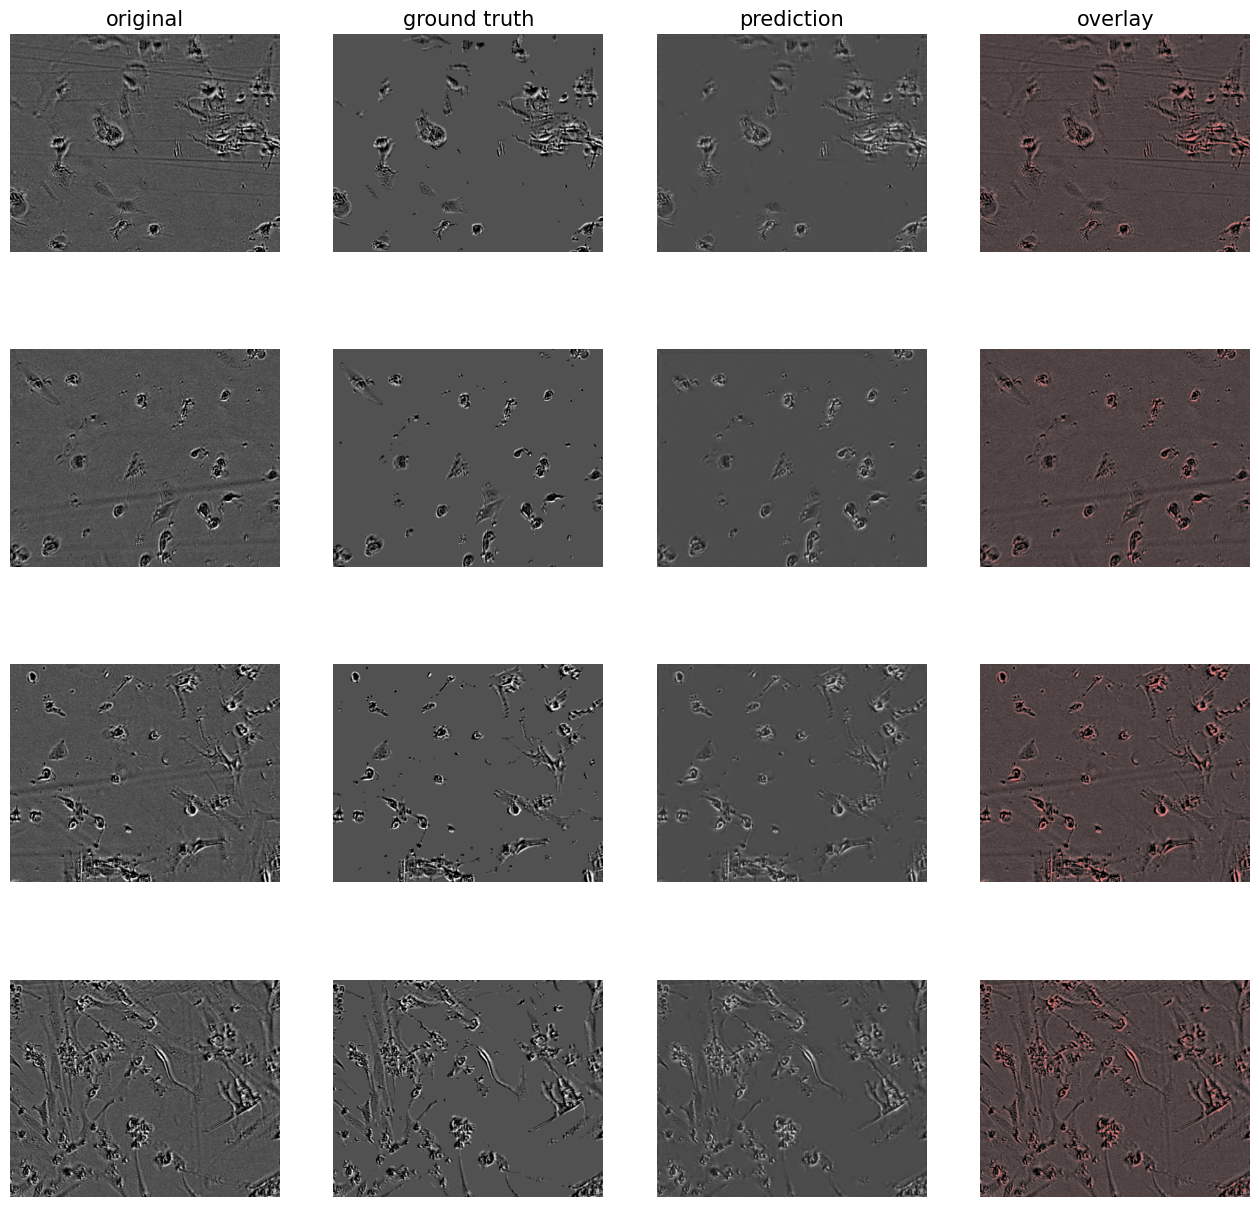

In [ ]:
# Looking at the test images

plot_imgs(org_imgs=X_test, mask_imgs=Y_test, pred_imgs=Y_pred, nm_img_to_plot=X_test.shape[0])

Below are comparisons of a test image and its prediction.

In [ ]:
np.save('Y_test', Y_test)
np.save('Y_pred', Y_pred)


In [ ]:
# Choose one pair of original and predicted test images (Here the first)
y_test = copy.deepcopy(Y_test[0, :, :, 0])
y_pred = copy.deepcopy(Y_pred[0, :, :, 0])

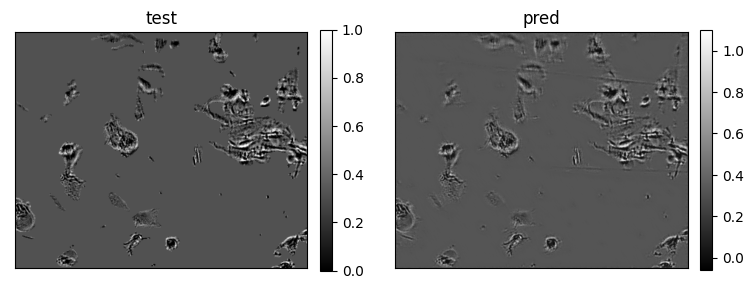

In [ ]:
# Plot one original and corresponding predicted test image on their own colorscale each
fig, ax = plt.subplots(1, 2, figsize = (9, 5))

im1 = ax[0].imshow(y_test, cmap = 'gray')
ax[0].set_title('test')
ax[0].set_xticks([])
ax[0].set_yticks([])
fig.colorbar(im1, ax = ax[0], fraction = 0.038, pad = 0.04)

im2 = ax[1].imshow(y_pred, cmap = 'gray')
ax[1].set_title('pred')
ax[1].set_xticks([])
ax[1].set_yticks([])
fig.colorbar(im2, ax = ax[1], fraction = 0.038, pad = 0.04)

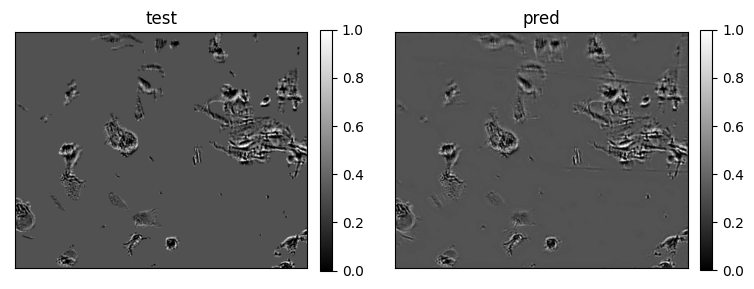

In [ ]:
# Plot one original and corresponding predicted test image on the same scale [0, 1]
fig, ax = plt.subplots(1, 2, figsize = (9, 5))

im1 = ax[0].imshow(y_test, cmap = 'gray', vmin = 0, vmax = 1)
ax[0].set_title('test')
ax[0].set_xticks([])
ax[0].set_yticks([])
fig.colorbar(im1, ax = ax[0], fraction = 0.038, pad = 0.04)

im2 = ax[1].imshow(y_pred, cmap = 'gray', vmin = 0, vmax = 1)
ax[1].set_title('pred')
ax[1].set_xticks([])
ax[1].set_yticks([])
fig.colorbar(im2, ax = ax[1], fraction = 0.038, pad = 0.04)

Text(0.5, 1.0, 'pred')

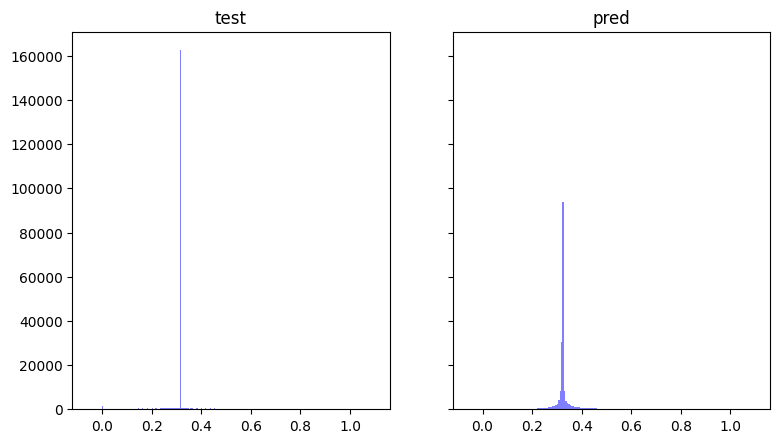

In [ ]:
# Look at the histograms of one original and corresponding predicted test image
y_test = copy.deepcopy(Y_test[0, :, :, 0].flatten())
y_pred = copy.deepcopy(Y_pred[0, :, :, 0].flatten())

fig, ax = plt.subplots(1, 2, figsize = (9, 5), sharex = True, sharey = True)

ax[0].hist(y_test, 200, facecolor = 'blue', alpha = 0.5)
ax[0].set_title('test')

ax[1].hist(y_pred, 200, facecolor = 'blue', alpha = 0.5)
ax[1].set_title('pred')

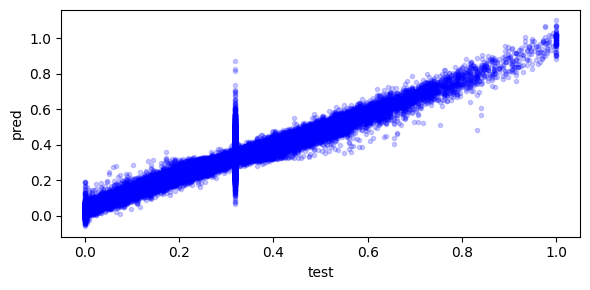

In [ ]:
# Plot one original and corresponding predicted image against each other 
plt.figure(figsize=(6, 3))
plt.plot(y_test, y_pred, 'b.', alpha=0.2)
plt.xlabel('test')
plt.ylabel('pred')
plt.tight_layout()